Summary: Using area and depth information to create a volume array works for regular lat/lon grids and rotated pole grids, but not curvilinear grids.

In [1]:
import os, sys
import numpy
import iris

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import general_io as gio
import timeseries
import grids
import convenient_universal as uconv
import spatial_weights

In [2]:
%matplotlib inline

In [47]:
volume_file = '/g/data/ua6/DRSv2/CMIP5/IPSL-CM5A-LR/historical/fx/ocean/r0i0p0/volcello/latest/volcello_fx_IPSL-CM5A-LR_historical_r0i0p0.nc'
area_file = '/g/data/ua6/DRSv2/CMIP5/IPSL-CM5A-LR/historical/fx/ocean/r0i0p0/areacello/latest/areacello_fx_IPSL-CM5A-LR_historical_r0i0p0.nc'
data_file = '/g/data/ua6/DRSv2/CMIP5/IPSL-CM5A-LR/historical/mon/ocean/r1i1p1/thetao/latest/thetao_Omon_IPSL-CM5A-LR_historical_r1i1p1_185001-189912.nc'

In [48]:
area_cube = iris.load_cube(area_file)
area_cube

<iris 'Cube' of cell_area / (m2) (cell index along second dimension: 149; cell index along first dimension: 182)>

In [49]:
volume_cube = iris.load_cube(volume_file)
volume_cube 

<iris 'Cube' of ocean_volume / (m3) (depth: 31; cell index along second dimension: 149; cell index along first dimension: 182)>

In [50]:
data_cube = iris.load_cube(data_file, 'sea_water_potential_temperature')
data_cube

<iris 'Cube' of sea_water_potential_temperature / (K) (time: 600; depth: 31; cell index along second dimension: 149; cell index along first dimension: 182)>

In [51]:
area_file_broadcast_data = uconv.broadcast_array(area_cube.data, [2, 3], data_cube.shape)

In [52]:
print(area_file_broadcast_data.shape)

(600, 31, 149, 182)


In [53]:
def get_depth_data(target_cube):
    """Get the depth data array"""

    depth_axis = target_cube.coord('depth')
    coord_names = [coord.name() for coord in target_cube.dim_coords]
    
    assert depth_axis.units in ['m', 'dbar'], "Unrecognised depth axis units"
    if depth_axis.units == 'm':
        vertical_weights = spatial_weights.calc_vertical_weights_1D(depth_axis, coord_names, target_cube.shape)
    elif depth_axis.units == 'dbar':
        assert coord_names == ['depth', 'latitude', 'longitude'], "2D weights will not work for curvilinear grid"
        vertical_weights = spatial_weights.calc_vertical_weights_2D(depth_axis, target_cube.coord('latitude'), coord_names, target_cube.shape)

    return vertical_weights

In [54]:
depth_data = get_depth_data(data_cube)

In [55]:
print(depth_data.shape)
print(depth_data.min())
print(depth_data.max())

(600, 31, 149, 182)
10.0000152588
500.453125


In [56]:
calc_volume_data = depth_data * area_file_broadcast_data

In [57]:
calc_volume_data.shape

(600, 31, 149, 182)

In [58]:
volume_cube.data.shape

(31, 149, 182)

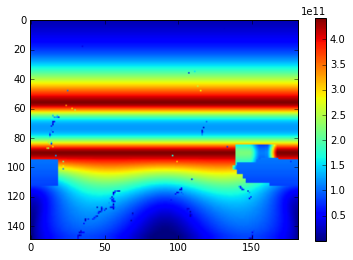

In [59]:
plt.imshow(volume_cube.data[-5, ::])
plt.colorbar()
plt.show()

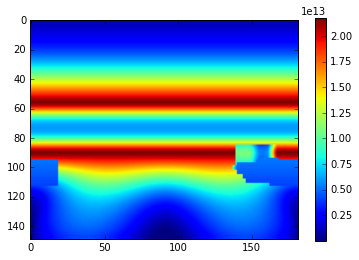

In [60]:
plt.imshow(calc_volume_data[0, -5, ::])
plt.colorbar()
plt.show()

In [62]:
volume_cube.data[:, 100, 100]

array([  1.57332244e+13,   1.57154772e+13,   1.56810284e+13,
         1.56143704e+13,   1.54861862e+13,   1.52425831e+13,
         1.47898856e+13,   1.39825722e+13,   1.26433142e+13,
         1.06674677e+13,   8.20456718e+12,   5.70624154e+12,
         3.64941096e+12,   2.22773772e+12,   1.35973529e+12,
         8.69325865e+11,   6.04325806e+11,   4.64570057e+11,
         3.91810384e+11,   3.54184593e+11,   3.34795145e+11,
         3.24821287e+11,   3.19695553e+11,   3.17062578e+11,
         3.15710407e+11,   3.15016086e+11,   3.14659602e+11,
         3.14476528e+11,   3.14382582e+11,   3.14334314e+11,
         3.14309542e+11], dtype=float32)

In [63]:
calc_volume_data[0, :, 100, 100]

array([  3.14310030e+11,   3.14335269e+11,   3.14384427e+11,
         3.14480167e+11,   3.14666611e+11,   3.15029667e+11,
         3.15737074e+11,   3.17114241e+11,   3.19796155e+11,
         3.25017062e+11,   3.35175674e+11,   3.54921695e+11,
         3.93231769e+11,   4.67286065e+11,   6.09419821e+11,
         8.78552169e+11,   1.37536039e+12,   2.25104504e+12,
         3.67675222e+12,   5.72564321e+12,   8.20299774e+12,
         1.06461118e+13,   1.26159986e+13,   1.39602359e+13,
         1.47752346e+13,   1.52340375e+13,   1.54814949e+13,
         1.56118766e+13,   1.56797263e+13,   1.57148022e+13,
         1.57297197e+13])

In [64]:
print('volume:', volume_cube.data[0, 100, 100])
print('area:', area_cube.data[100, 100])
print('depth:', depth_data[0, 0, 100, 100])

volume: 1.57332e+13
area: 3.1431e+10
depth: 10.0000152588


In [20]:
volume_cube.coord('depth')

DimCoord(array([  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
         3.50000000e+01,   4.50000000e+01,   5.50000000e+01,
         6.50000000e+01,   7.50000000e+01,   8.50000000e+01,
         9.50000000e+01,   1.05000000e+02,   1.15000000e+02,
         1.25000000e+02,   1.35000000e+02,   1.45000000e+02,
         1.55000000e+02,   1.65098389e+02,   1.75479004e+02,
         1.86291306e+02,   1.97660294e+02,   2.09711395e+02,
         2.22578293e+02,   2.36408798e+02,   2.51370193e+02,
         2.67654205e+02,   2.85483673e+02,   3.05119202e+02,
         3.26868011e+02,   3.51093506e+02,   3.78227600e+02,
         4.08784607e+02,   4.43377686e+02,   4.82736694e+02,
         5.27727966e+02,   5.79372864e+02,   6.38862610e+02,
         7.07563293e+02,   7.87002502e+02,   8.78825195e+02,
         9.84705933e+02,   1.10620398e+03,   1.24456702e+03,
         1.40049695e+03,   1.57394592e+03,   1.76400293e+03,
         1.96894397e+03,   2.18645703e+03,   2.41397192e+03,
         2.6490

In [21]:
data_cube.coord('depth')

DimCoord(array([  5.00000000e+00,   1.50000000e+01,   2.50000000e+01,
         3.50000000e+01,   4.50000000e+01,   5.50000000e+01,
         6.50000000e+01,   7.50000000e+01,   8.50000000e+01,
         9.50000000e+01,   1.05000000e+02,   1.15000000e+02,
         1.25000000e+02,   1.35000000e+02,   1.45000000e+02,
         1.55000000e+02,   1.65098389e+02,   1.75479004e+02,
         1.86291306e+02,   1.97660294e+02,   2.09711395e+02,
         2.22578293e+02,   2.36408798e+02,   2.51370193e+02,
         2.67654205e+02,   2.85483673e+02,   3.05119202e+02,
         3.26868011e+02,   3.51093506e+02,   3.78227600e+02,
         4.08784607e+02,   4.43377686e+02,   4.82736694e+02,
         5.27727966e+02,   5.79372864e+02,   6.38862610e+02,
         7.07563293e+02,   7.87002502e+02,   8.78825195e+02,
         9.84705933e+02,   1.10620398e+03,   1.24456702e+03,
         1.40049695e+03,   1.57394592e+03,   1.76400293e+03,
         1.96894397e+03,   2.18645703e+03,   2.41397192e+03,
         2.6490

In [43]:
data_cube[0, ::] * volume_cube[::-1, ::]

ValueError: This operation cannot be performed as there are differing coordinates (depth) remaining which cannot be ignored.

In [47]:
volume_cube[::-1, ::].coord('depth').bounds

array([[   10.        ,     0.        ],
       [   20.        ,    10.        ],
       [   30.19999886,    20.        ],
       [   40.39999771,    30.19999886],
       [   50.79999924,    40.39999771],
       [   61.39999771,    50.79999924],
       [   72.19999695,    61.39999771],
       [   83.19999695,    72.19999695],
       [   94.59999847,    83.19999695],
       [  106.3999939 ,    94.59999847],
       [  118.79999542,   106.3999939 ],
       [  132.19999695,   118.79999542],
       [  146.79998779,   132.19999695],
       [  163.        ,   146.79998779],
       [  181.3999939 ,   163.        ],
       [  202.79998779,   181.3999939 ],
       [  228.        ,   202.79998779],
       [  258.19998169,   228.        ],
       [  295.        ,   258.19998169],
       [  340.3999939 ,   295.        ],
       [  396.79998779,   340.3999939 ],
       [  466.99996948,   396.79998779],
       [  554.        ,   466.99996948],
       [  661.39996338,   554.        ],
       [  792.19

In [48]:
data_cube.coord('depth').bounds

array([[    0.        ,    10.        ],
       [   10.        ,    20.        ],
       [   20.        ,    30.19999886],
       [   30.19999886,    40.39999771],
       [   40.39999771,    50.79999924],
       [   50.79999924,    61.39999771],
       [   61.39999771,    72.19999695],
       [   72.19999695,    83.19999695],
       [   83.19999695,    94.59999847],
       [   94.59999847,   106.3999939 ],
       [  106.3999939 ,   118.79999542],
       [  118.79999542,   132.19999695],
       [  132.19999695,   146.79998779],
       [  146.79998779,   163.        ],
       [  163.        ,   181.3999939 ],
       [  181.3999939 ,   202.79998779],
       [  202.79998779,   228.        ],
       [  228.        ,   258.19998169],
       [  258.19998169,   295.        ],
       [  295.        ,   340.3999939 ],
       [  340.3999939 ,   396.79998779],
       [  396.79998779,   466.99996948],
       [  466.99996948,   554.        ],
       [  554.        ,   661.39996338],
       [  661.39

In [50]:
data_cube[0, -1, ::].data

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = 1e+20)

In [51]:
volume_cube[::-1, ::].coord('depth').points

array([  5.00000000e+00,   1.50000000e+01,   2.50999985e+01,
         3.52999992e+01,   4.55999985e+01,   5.60999985e+01,
         6.67999954e+01,   7.76999969e+01,   8.88999939e+01,
         1.00500000e+02,   1.12599998e+02,   1.25500000e+02,
         1.39500000e+02,   1.54899994e+02,   1.72199997e+02,
         1.92099991e+02,   2.15399994e+02,   2.43099991e+02,
         2.76599976e+02,   3.17699982e+02,   3.68599976e+02,
         4.31899994e+02,   5.10500000e+02,   6.07699951e+02,
         7.26799988e+02,   8.70799988e+02,   1.04209998e+03,
         1.24209998e+03,   1.47109998e+03,   1.72809998e+03,
         2.01089990e+03,   2.31659985e+03,   2.64200000e+03,
         2.98379980e+03,   3.33889990e+03,   3.70459985e+03,
         4.07859985e+03,   4.45900000e+03,   4.84429980e+03,
         5.23329980e+03])

In [53]:
numpy.array_equal(volume_cube[::-1, ::].coord('depth').points, data_cube.coord('depth').points)

True

In [58]:
calc_volume_data[0, :, 150, 150]

masked_array(data = [102463385600.0 102463385600.0 104512641585.9961 104512641585.9961
 106561936658.67188 108611173101.32812 110660448630.66406 112709724160.0
 116808275218.67188 120906748103.98438 127054613778.67188
 137300952338.67188 149596449167.96875 165990809749.375 188532566965.3125
 219271582645.3125 258207856789.375 309439236895.9375 377065446624.0625
 465183708085.3125 577893432245.3125 719292779295.9375 891431767413.4375
 1100456386111.875 1340220958570.625 1610724546709.375 1899670793791.875
 2198864004821.25 2493959055658.75 2772658964181.25 3022669875200.0
 3241940519765.0 3426377115392.5 3578020924842.5 3698928220160.0
 3795242802005.0 3869018440875.0 3926393934335.0 3969435560620.0
 4002215839060.0],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False],
       

In [59]:
volume_cube[::-1, ::].data[:, 150, 150]

masked_array(data = [102463389696.0 102463389696.0 104512659456.0 104512659456.0 106561929216.0
 108611190784.0 110660460544.0 112709730304.0 116808261632.0 120906801152.0
 127054602240.0 137300942848.0 149596553216.0 165990694912.0 188532637696.0
 219271659520.0 258207744000.0 309439430656.0 377065275392.0 465183801344.0
 577893498880.0 719292989440.0 891431485440.0 1100456787968.0
 1340221161472.0 1610724540416.0 1899671191552.0 2198864396288.0
 2493958848512.0 2772659339264.0 3022670004224.0 3241941663744.0
 3426375696384.0 3578021543936.0 3698928386048.0 3795244023808.0
 3869017636864.0 3926397026304.0 -- --],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True],
       fill_value = 1e+20)

In [60]:
calc_volume_data.mask = data_cube.data.mask

In [61]:
calc_volume_data[0, :, 150, 150]

masked_array(data = [102463385600.0 102463385600.0 104512641585.9961 104512641585.9961
 106561936658.67188 108611173101.32812 110660448630.66406 112709724160.0
 116808275218.67188 120906748103.98438 127054613778.67188
 137300952338.67188 149596449167.96875 165990809749.375 188532566965.3125
 219271582645.3125 258207856789.375 309439236895.9375 377065446624.0625
 465183708085.3125 577893432245.3125 719292779295.9375 891431767413.4375
 1100456386111.875 1340220958570.625 1610724546709.375 1899670793791.875
 2198864004821.25 2493959055658.75 2772658964181.25 3022669875200.0
 3241940519765.0 3426377115392.5 3578020924842.5 3698928220160.0
 3795242802005.0 3869018440875.0 3926393934335.0 -- --],
             mask = [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True],
       fill_value = 1e+20)

## Check NorESM-1

In [67]:
hist_volume = iris.load_cube('/g/data/ua6/DRSv2/CMIP5/NorESM1-M/historical/fx/ocean/r0i0p0/volcello/latest/volcello_fx_NorESM1-M_historical_r0i0p0.nc')
control_volume = iris.load_cube('/g/data/ua6/DRSv2/CMIP5/NorESM1-M/piControl/fx/ocean/r0i0p0/volcello/latest/volcello_fx_NorESM1-M_piControl_r0i0p0.nc')

In [68]:
hist_volume

<iris 'Cube' of ocean_volume / (m3) (depth: 70; cell index along second dimension: 384; cell index along first dimension: 320)>

In [69]:
control_volume

<iris 'Cube' of ocean_volume / (m3) (depth: 70; cell index along second dimension: 384; cell index along first dimension: 320)>

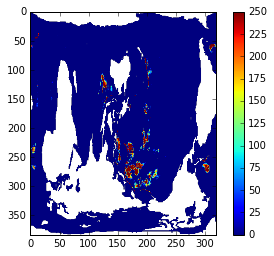

In [70]:
plt.imshow(hist_volume.data[-5, ::])
plt.colorbar()
plt.show()

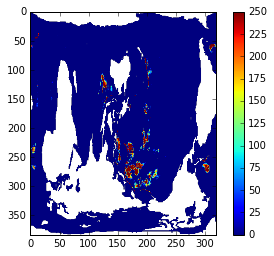

In [71]:
plt.imshow(control_volume.data[-5, ::])
plt.colorbar()
plt.show()

In [72]:
hist_depth = iris.load_cube('/g/data/ua6/DRSv2/CMIP5/NorESM1-M/historical/fx/ocean/r0i0p0/deptho/latest/deptho_fx_NorESM1-M_historical_r0i0p0.nc')
control_depth = iris.load_cube('/g/data/ua6/DRSv2/CMIP5/NorESM1-M/piControl/fx/ocean/r0i0p0/deptho/latest/deptho_fx_NorESM1-M_piControl_r0i0p0.nc')

In [73]:
hist_depth

<iris 'Cube' of sea_floor_depth_below_geoid / (m) (cell index along second dimension: 384; cell index along first dimension: 320)>

In [74]:
hist_volume.coord('depth')

DimCoord(array([  0.00000000e+00,   5.00000000e+00,   1.00000000e+01,
         1.50000000e+01,   2.00000000e+01,   2.50000000e+01,
         3.00000000e+01,   4.00000000e+01,   5.00000000e+01,
         6.25000000e+01,   7.50000000e+01,   8.75000000e+01,
         1.00000000e+02,   1.12500000e+02,   1.25000000e+02,
         1.37500000e+02,   1.50000000e+02,   1.75000000e+02,
         2.00000000e+02,   2.25000000e+02,   2.50000000e+02,
         2.75000000e+02,   3.00000000e+02,   3.50000000e+02,
         4.00000000e+02,   4.50000000e+02,   5.00000000e+02,
         5.50000000e+02,   6.00000000e+02,   6.50000000e+02,
         7.00000000e+02,   7.50000000e+02,   8.00000000e+02,
         8.50000000e+02,   9.00000000e+02,   9.50000000e+02,
         1.00000000e+03,   1.05000000e+03,   1.10000000e+03,
         1.15000000e+03,   1.20000000e+03,   1.25000000e+03,
         1.30000000e+03,   1.35000000e+03,   1.40000000e+03,
         1.45000000e+03,   1.50000000e+03,   1.62500000e+03,
         1.7500